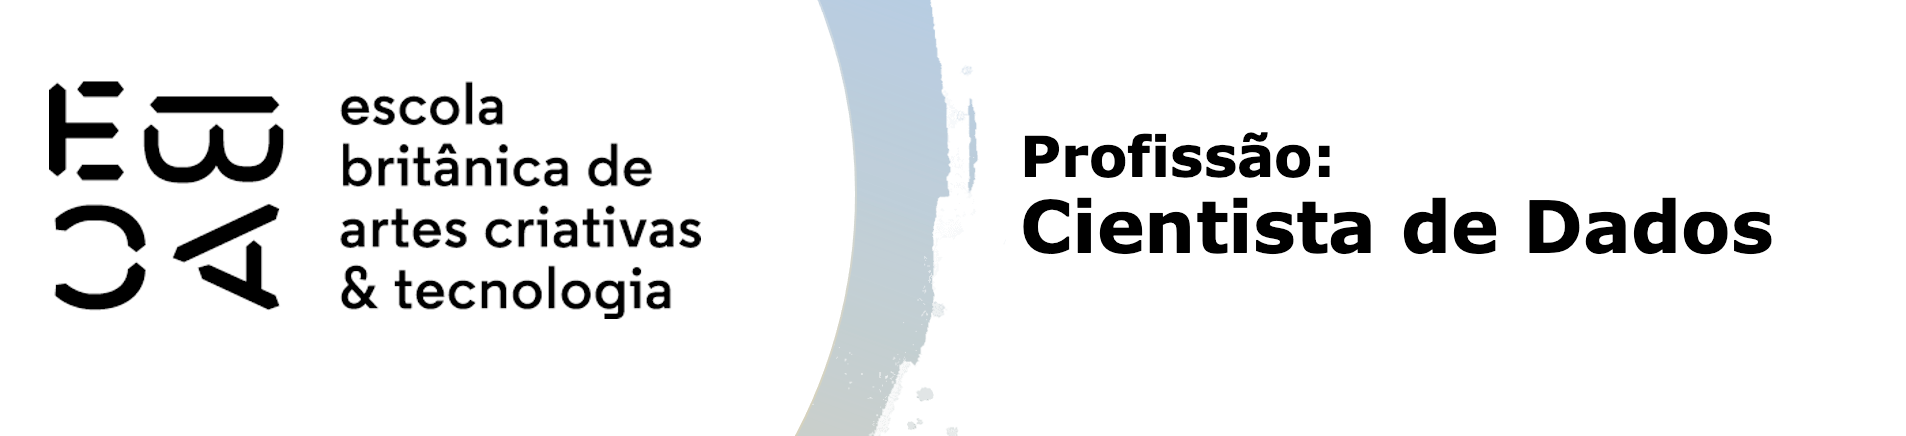

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
# Importando as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pickle

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from scipy.stats import ks_2samp
from scipy.stats import t
from pycaret.classification import *

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

In [2]:
# Carregando a Base de Dados
df = pd.read_feather('credit_scoring.ftr')
# Transformar a variável resposta em inteiro
df['mau'] = df.mau.astype('int64')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,0
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,0
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,0
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,0


In [3]:
# Visualizando a estrutura da base de dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [4]:
# Ordenando a base de dados
df = df.sort_values(by='data_ref')

In [5]:
# Definindo a data de corte
data_max = df['data_ref'].max()
data_corte = data_max - pd.DateOffset(months=2)

In [6]:
# Separando dados de treino e de validação
df_treino = df[df['data_ref'] < data_corte]
df_validacao = df[df['data_ref'] >= data_corte]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
# Visualizando datas
df_validacao['data_ref'].unique()

<DatetimeArray>
['2016-01-01 00:00:00', '2016-02-01 00:00:00', '2016-03-01 00:00:00']
Length: 3, dtype: datetime64[ns]

In [8]:
# Visualizando datas
df_treino['data_ref'].unique()

<DatetimeArray>
['2015-01-01 00:00:00', '2015-02-01 00:00:00', '2015-03-01 00:00:00',
 '2015-04-01 00:00:00', '2015-05-01 00:00:00', '2015-06-01 00:00:00',
 '2015-07-01 00:00:00', '2015-08-01 00:00:00', '2015-09-01 00:00:00',
 '2015-10-01 00:00:00', '2015-11-01 00:00:00', '2015-12-01 00:00:00']
Length: 12, dtype: datetime64[ns]

Text(0.5, 1.0, 'Número de linhas para cada mês da base de treino')

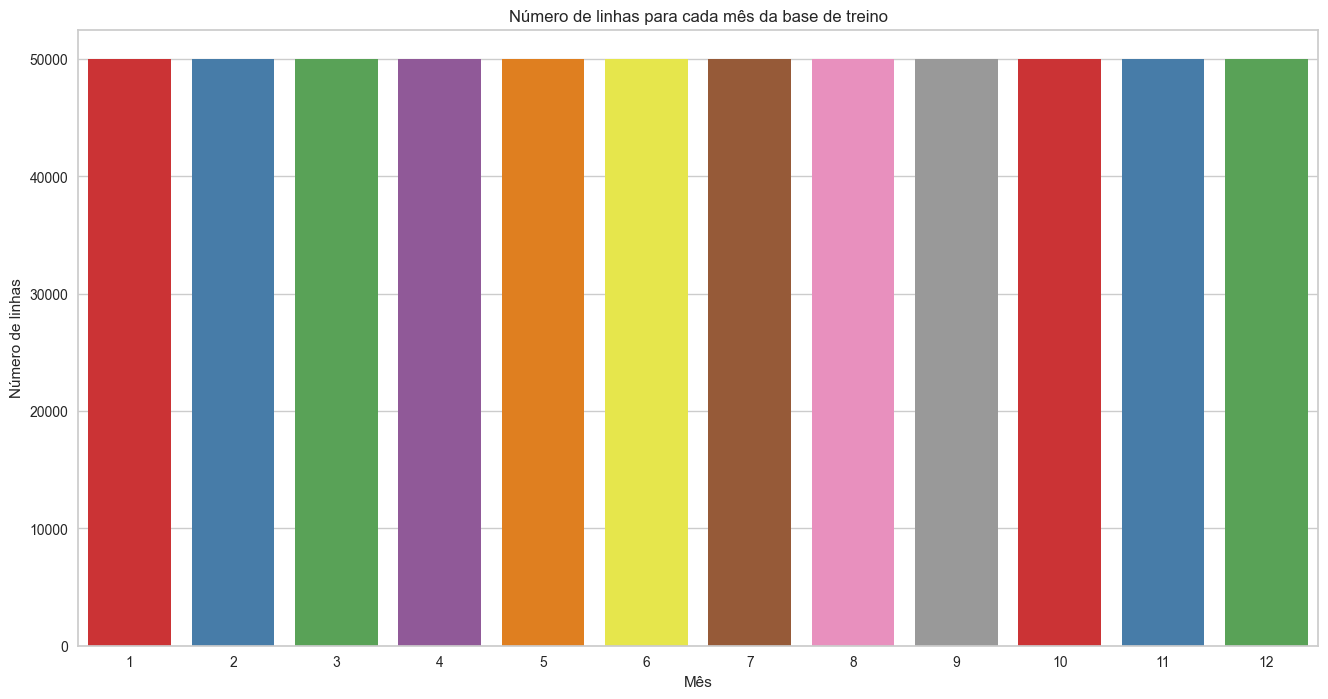

In [9]:
# Visualização gráfica número de linhas para cada mês
fig, ax = plt.subplots(figsize=(16,8))
mes = df_treino['data_ref'].dt.month
sns.countplot(data=df_treino, x=mes,hue=mes, palette='Set1', ax=ax, legend=False)
ax.set_xlabel('Mês')
ax.set_ylabel('Número de linhas')
ax.set_title('Número de linhas para cada mês da base de treino')

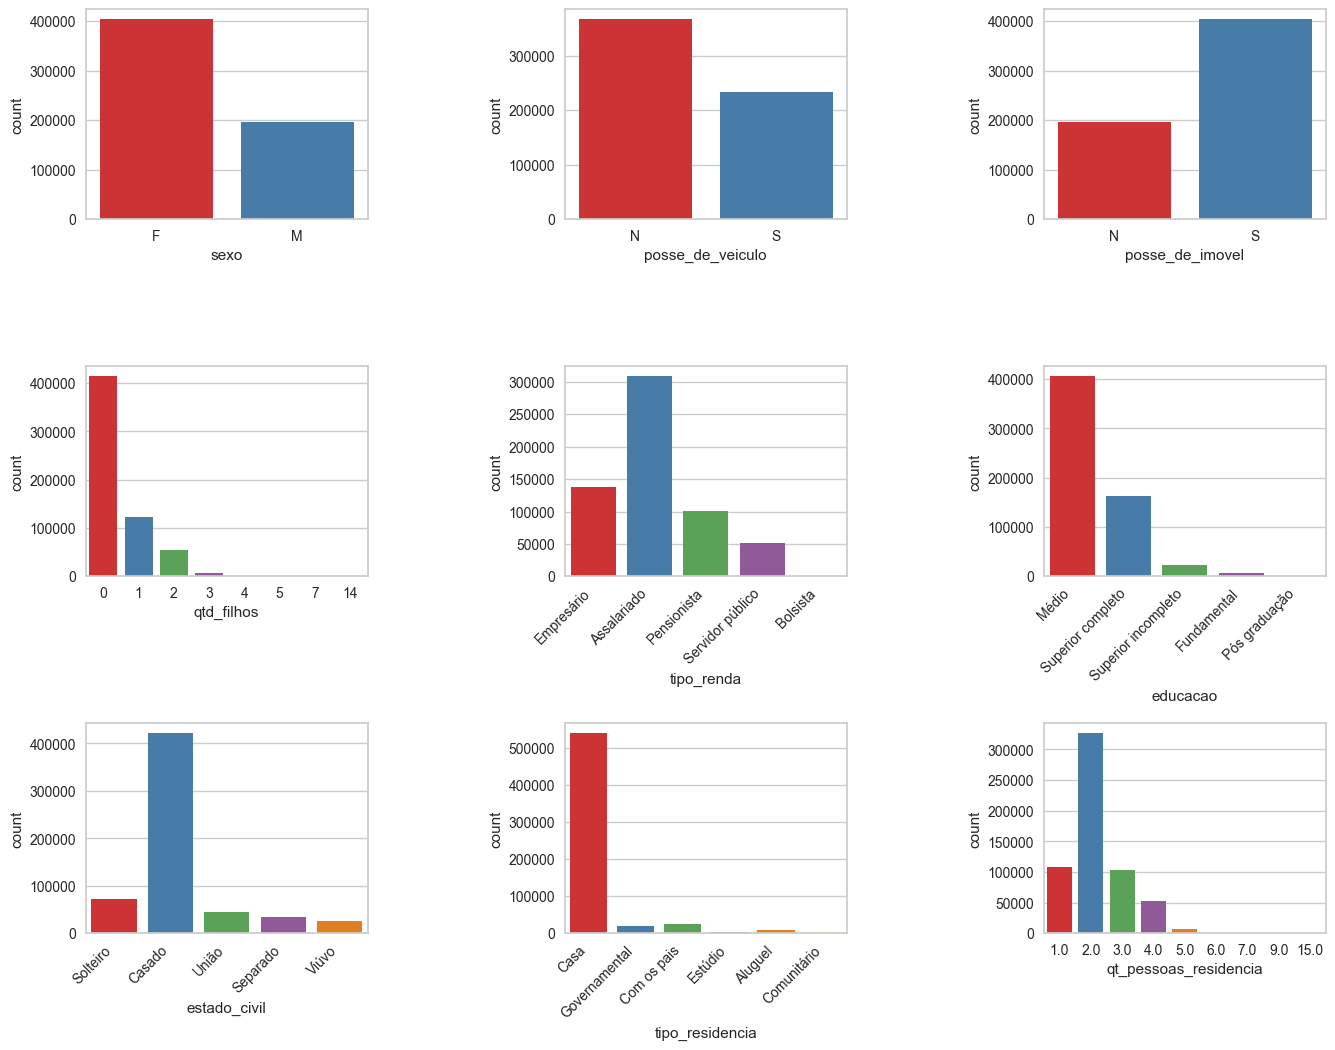

In [10]:
# Visualização Gráfica das Variáveis Qualitativas ou Quantitativas Discretas
plt.rc('figure', figsize=(16, 12))
fig, axes = plt.subplots(3, 3)

sns.countplot(ax=axes[0, 0], x='sexo', data=df_treino, hue='sexo', palette='Set1', legend=False)
sns.countplot(ax=axes[0, 1], x='posse_de_veiculo', data=df_treino, hue='posse_de_veiculo', palette='Set1', legend=False)
sns.countplot(ax=axes[0, 2], x='posse_de_imovel', data=df_treino, hue='posse_de_imovel', palette='Set1', legend=False)
sns.countplot(ax=axes[1, 0], x='qtd_filhos', data=df_treino, hue='qtd_filhos', palette='Set1', legend=False)
sns.countplot(ax=axes[1, 1], x='tipo_renda', data=df_treino, hue='tipo_renda', palette='Set1', legend=False)
axes[1, 1].set_xticks(range(len(df_treino['tipo_renda'].unique())))
axes[1, 1].set_xticklabels(df_treino['tipo_renda'].unique(), rotation=45, ha='right')
sns.countplot(ax=axes[1, 2], x='educacao', data=df_treino, hue='educacao', palette='Set1', legend=False)
axes[1, 2].set_xticks(range(len(df_treino['educacao'].unique())))
axes[1, 2].set_xticklabels(df_treino['educacao'].unique(), rotation=45, ha='right')
sns.countplot(ax=axes[2, 0], x='estado_civil', data=df_treino, hue='estado_civil', palette='Set1', legend=False)
axes[2, 0].set_xticks(range(len(df_treino['estado_civil'].unique())))
axes[2, 0].set_xticklabels(df_treino['estado_civil'].unique(), rotation=45, ha='right')
sns.countplot(ax=axes[2, 1], x='tipo_residencia', data=df_treino, hue='tipo_residencia', palette='Set1', legend=False)
axes[2, 1].set_xticks(range(len(df_treino['tipo_residencia'].unique())))
axes[2, 1].set_xticklabels(df_treino['tipo_residencia'].unique(), rotation=45, ha='right')
sns.countplot(ax=axes[2, 2], x='qt_pessoas_residencia', data=df_treino, hue='qt_pessoas_residencia', palette='Set1', legend=False)

# Ajustar o espaçamento
plt.subplots_adjust(wspace=0.7, hspace=0.7)

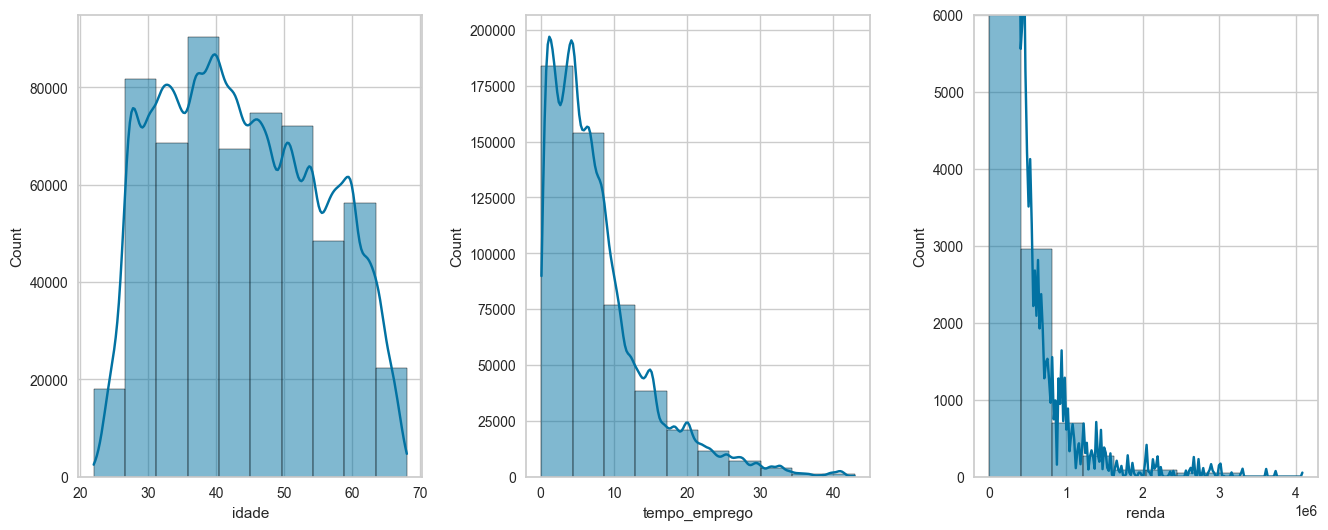

In [11]:
# Visualização Gráfica das Variáveis Quantitativas Contínuas via histograma
plt.rc('figure', figsize=(16, 6))
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(df_treino['idade'], bins=10, kde = True, ax = axes[0])
sns.histplot(df_treino['tempo_emprego'], bins=10, kde = True, ax = axes[1])
# Apresentando o gráfico de renda com limitação de escala em função da distorção do eixo y em relação ao eixo x
sns.histplot(df_treino['renda'], bins=10, kde=True, ax=axes[2])
axes[2].set_ylim(0, 6000)  # Defina o limite superior do eixo y

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.3)


## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

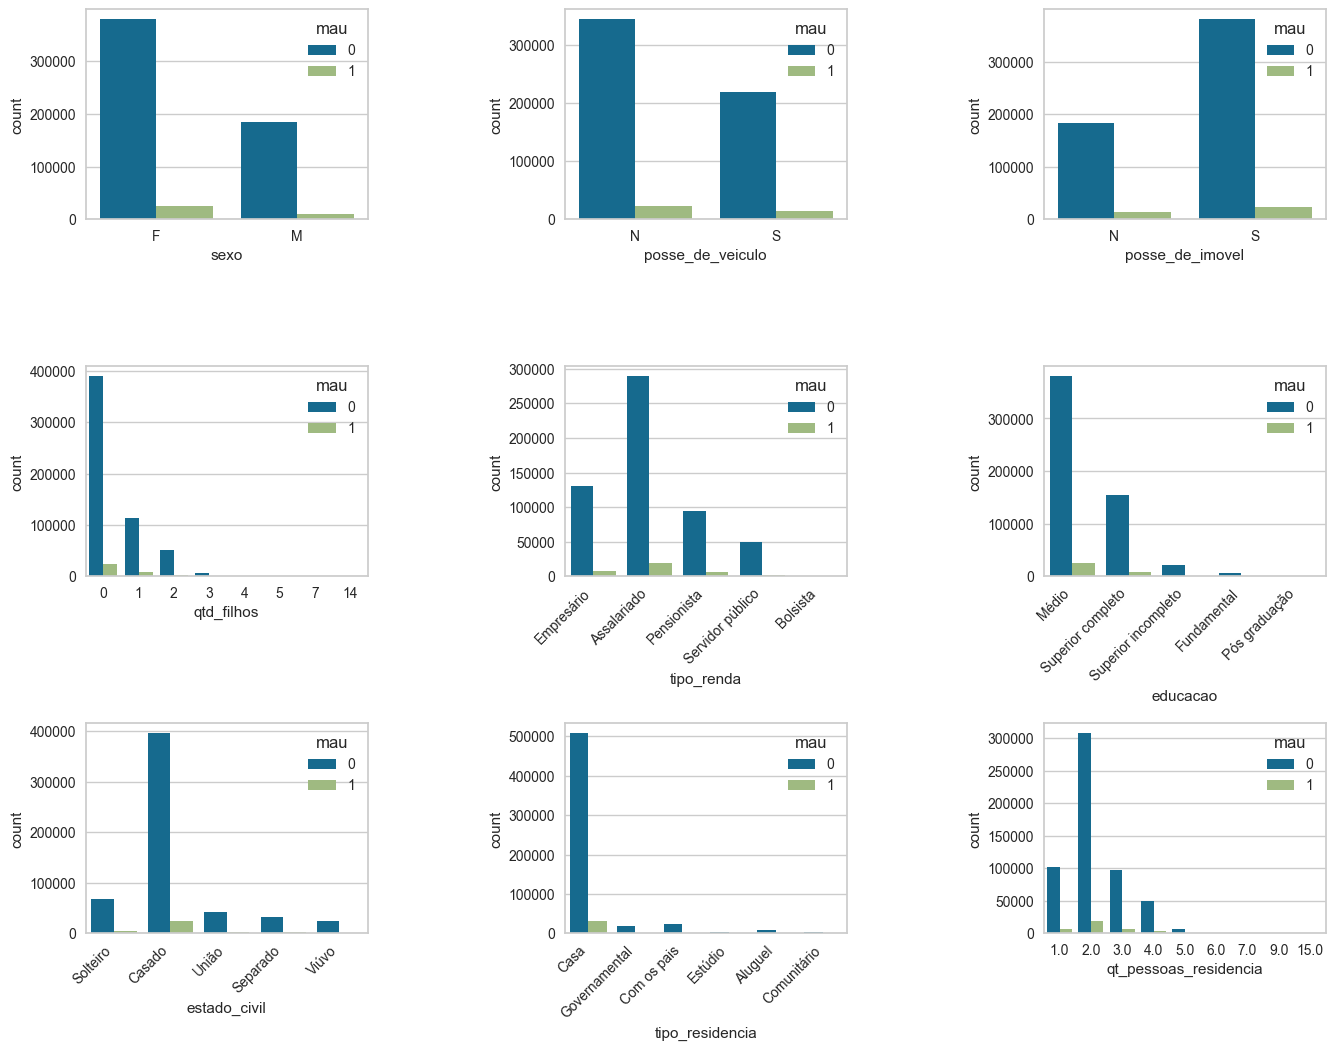

In [12]:
# Visualização Gráfica das Variáveis Qualitativas ou Quantitativas Discretas
plt.rc('figure', figsize=(16, 12))
fig, axes = plt.subplots(3, 3)

sns.countplot(ax = axes[0, 0], x='sexo', hue='mau', data=df_treino)
sns.countplot(ax = axes[0, 1], x='posse_de_veiculo', hue='mau', data=df_treino)
sns.countplot(ax = axes[0, 2], x='posse_de_imovel', hue='mau', data=df_treino)
sns.countplot(ax = axes[1, 0], x='qtd_filhos', hue='mau', data=df_treino) 
sns.countplot(ax = axes[1, 1], x='tipo_renda', hue='mau', data=df_treino)
axes[1, 1].set_xticks(range(len(df_treino['tipo_renda'].unique())))
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[1, 2], x='educacao', hue='mau', data=df_treino)
axes[1, 2].set_xticks(range(len(df_treino['educacao'].unique())))
axes[1, 2].set_xticklabels(axes[1, 2].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 0], x='estado_civil', hue='mau', data=df_treino)
axes[2, 0].set_xticks(range(len(df_treino['estado_civil'].unique())))
axes[2, 0].set_xticklabels(axes[2, 0].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 1], x='tipo_residencia', hue='mau', data=df_treino)
axes[2, 1].set_xticks(range(len(df_treino['tipo_residencia'].unique())))
axes[2, 1].set_xticklabels(axes[2, 1].get_xticklabels(), rotation=45, ha='right')
sns.countplot(ax = axes[2, 2], x='qt_pessoas_residencia', hue='mau', data=df_treino)

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.7, hspace=0.7)

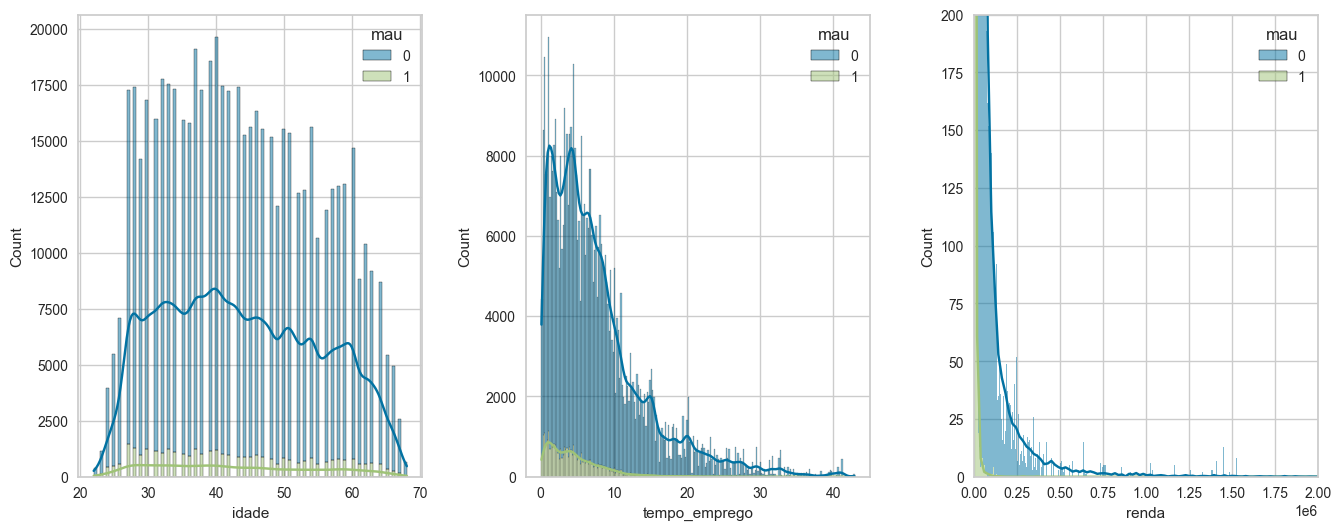

In [13]:
# Visualização Gráfica das Variáveis Quantitativas Contínuas via histograma
plt.rc('figure', figsize=(16, 6))
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

sns.histplot(data=df_treino, x='idade', hue='mau', multiple='stack', kde = True, ax = axes[0])
sns.histplot(data=df_treino, x='tempo_emprego', hue='mau', multiple='stack', kde = True, ax = axes[1])
# Apresentando o gráfico de renda com limitação de escala em função da distorção do eixo y em relação ao eixo x
sns.histplot(data=df_treino, x='renda', hue='mau', multiple='stack', kde = True, ax = axes[2])
axes[2].set_xlim(0, 2000000)  # Defina o limite superior do eixo x
axes[2].set_ylim(0, 200)  # Defina o limite superior do eixo y

#ajustar o espaçamento
plt.subplots_adjust(wspace=0.3)

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [14]:
# Removendo as variáveis 'data_ref' e 'index'
df_metadados = df_treino.drop(columns = ['data_ref', 'index'])

In [15]:
# Visualizando valores missing
df_metadados.isna().sum(axis=0)

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            100875
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [16]:
# Tratando valores missing
media = df_metadados['tempo_emprego'].mean()
df_metadados['tempo_emprego'] = df_metadados['tempo_emprego'].copy().fillna(media)

In [17]:
# Visualizando distribuição da variável 'mau'
df_metadados.mau.value_counts()

mau
0    563357
1     36643
Name: count, dtype: int64

In [18]:
# Gerando metadados
metadados = pd.DataFrame(df_metadados.dtypes, columns=['dtype'])
metadados['nmissing'] = df_metadados.isna().sum()
metadados['valores_unicos'] = df_metadados.nunique()
metadados['papel'] = 'covariavel'
metadados.loc['mau','papel'] = 'resposta'
metadados.loc['bom','papel'] = 'resposta'
metadados

,dtype,nmissing,valores_unicos,papel
sexo,object,0.0,2.0,covariavel
posse_de_veiculo,object,0.0,2.0,covariavel
posse_de_imovel,object,0.0,2.0,covariavel
qtd_filhos,int64,0.0,8.0,covariavel
tipo_renda,object,0.0,5.0,covariavel
educacao,object,0.0,5.0,covariavel
estado_civil,object,0.0,5.0,covariavel
tipo_residencia,object,0.0,6.0,covariavel
idade,int64,0.0,47.0,covariavel
tempo_emprego,float64,0.0,3005.0,covariavel


In [19]:
# Função para cálculo do IV
def IV(variavel, resposta):
    tab = pd.crosstab(variavel, resposta, margins=True, margins_name='total')

    rótulo_evento = tab.columns[0]
    rótulo_nao_evento = tab.columns[1]

    tab['pct_evento'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    tab['ep'] = tab[rótulo_evento]/tab.loc['total',rótulo_evento]
    
    tab['pct_nao_evento'] = tab[rótulo_nao_evento]/tab.loc['total',rótulo_nao_evento]
    tab['woe'] = np.log(tab.pct_evento/tab.pct_nao_evento)
    tab['iv_parcial'] = (tab.pct_evento - tab.pct_nao_evento)*tab.woe
    return tab['iv_parcial'].sum()

In [20]:
# Calculando o IV de cada variável
for var in metadados[metadados.papel=='covariavel'].index:
    if  (metadados.loc[var, 'valores_unicos']>6):
        metadados.loc[var, 'IV'] = IV(pd.qcut(df_metadados[var],5,duplicates='drop'), df_metadados.mau)
    else: 
        metadados.loc[var, 'IV'] = IV(df_metadados[var], df_metadados.mau)

    
metadados

,dtype,nmissing,valores_unicos,papel,IV
sexo,object,0.0,2.0,covariavel,0.002665
posse_de_veiculo,object,0.0,2.0,covariavel,0.000075
posse_de_imovel,object,0.0,2.0,covariavel,0.009690
qtd_filhos,int64,0.0,8.0,covariavel,0.000055
tipo_renda,object,0.0,5.0,covariavel,0.009718
educacao,object,0.0,5.0,covariavel,0.003690
estado_civil,object,0.0,5.0,covariavel,0.001305
tipo_residencia,object,0.0,6.0,covariavel,0.003330
idade,int64,0.0,47.0,covariavel,0.018434
tempo_emprego,float64,0.0,3005.0,covariavel,0.283956


In [21]:
# Função para cálculo da biv_discreta
def biv_discreta(var, df):
    df['bom'] = 1-df.mau
    g = df.groupby(var)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g['mau'].mean().index, 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,8))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]
    ax[0].set_xlim([-.3, num_cat-.7])

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[0].set_xticks(list(range(num_cat)))
    ax[0].set_xticklabels(biv[var], rotation=15)
    
    ax[1] = biv.cont.plot.bar()
    return biv

In [22]:
# Função para cálculo da biv_continua
def biv_continua(var, ncat, df):
    df['bom'] = 1-df.mau
    cat_srs, bins = pd.qcut(df[var], ncat, retbins=True, precision=0, duplicates='drop')
    g = df.groupby(cat_srs, observed=False)

    biv = pd.DataFrame({'qt_bom': g['bom'].sum(),
                        'qt_mau': g['mau'].sum(),
                        'mau':g['mau'].mean(), 
                        var: g[var].mean(), 
                        'cont':g[var].count()})
    
    biv['ep'] = (biv.mau*(1-biv.mau)/biv.cont)**.5
    biv['mau_sup'] = biv.mau+t.ppf([0.975], biv.cont-1)*biv.ep
    biv['mau_inf'] = biv.mau+t.ppf([0.025], biv.cont-1)*biv.ep
    
    biv['logit'] = np.log(biv.mau/(1-biv.mau))
    biv['logit_sup'] = np.log(biv.mau_sup/(1-biv.mau_sup))
    biv['logit_inf'] = np.log(biv.mau_inf/(1-biv.mau_inf))

    tx_mau_geral = df.mau.mean()
    woe_geral = np.log(df.mau.mean() / (1 - df.mau.mean()))

    biv['woe'] = biv.logit - woe_geral
    biv['woe_sup'] = biv.logit_sup - woe_geral
    biv['woe_inf'] = biv.logit_inf - woe_geral

    fig, ax = plt.subplots(2,1, figsize=(8,6))
    ax[0].plot(biv[var], biv.woe, ':bo', label='woe')
    ax[0].plot(biv[var], biv.woe_sup, 'o:r', label='limite superior')
    ax[0].plot(biv[var], biv.woe_inf, 'o:r', label='limite inferior')
    
    num_cat = biv.shape[0]

    ax[0].set_ylabel("Weight of Evidence")
    ax[0].legend(bbox_to_anchor=(.83, 1.17), ncol=3)
    
    ax[1] = biv.cont.plot.bar()
    return None

,qt_bom,qt_mau,mau,sexo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
sexo,,,,,,,,,,,,,,
F,378318,25487,0.063117,F,403805,0.000383,0.063867,0.062367,-2.697567,-2.684953,-2.710321,0.035125,0.047739,0.02237
M,185039,11156,0.056862,M,196195,0.000523,0.057887,0.055837,-2.808589,-2.789641,-2.827861,-0.075898,-0.056950,-0.09517


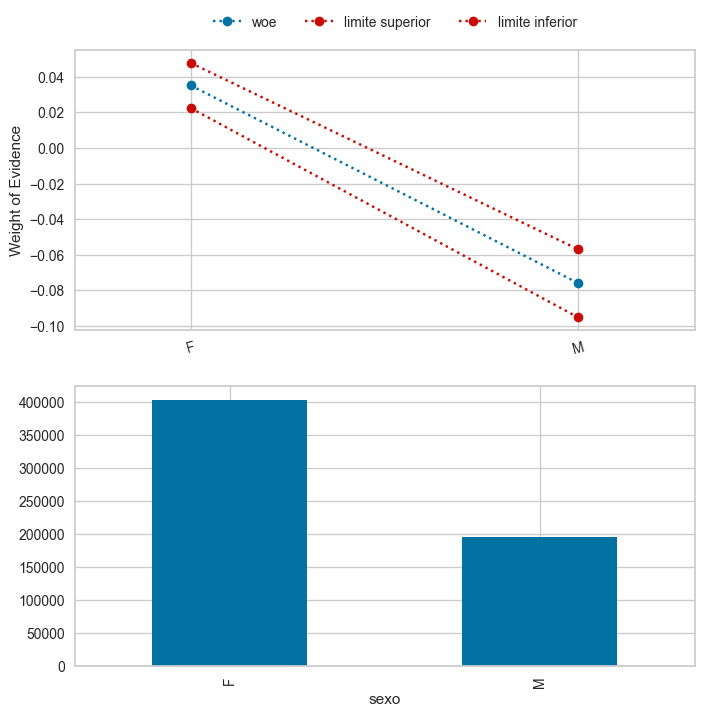

In [23]:
# Realizando o cálculo para a variável 'sexo'
pd.options.mode.copy_on_write = True 
biv_discreta('sexo', df_metadados)

,qt_bom,qt_mau,mau,posse_de_veiculo,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_veiculo,,,,,,,,,,,,,,
N,343778,22515,0.061467,N,366293,0.000397,0.062245,0.060689,-2.725814,-2.712410,-2.739378,0.006877,0.020281,-0.006687
S,219579,14128,0.060452,S,233707,0.000493,0.061418,0.059486,-2.743553,-2.726667,-2.760694,-0.010862,0.006024,-0.028003


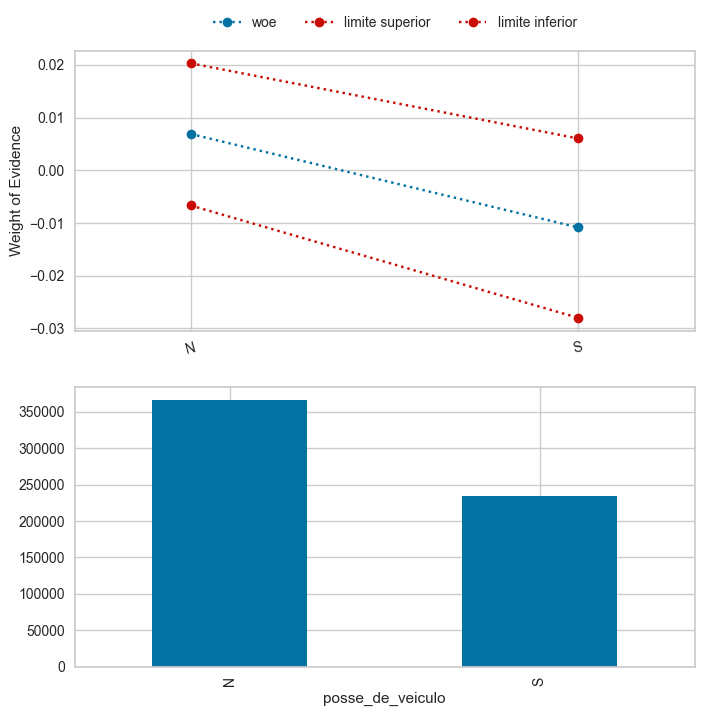

In [24]:
# Realizando o cálculo para a variável 'posse_de_veiculo'
biv_discreta('posse_de_veiculo', df_metadados)

,qt_bom,qt_mau,mau,posse_de_imovel,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
posse_de_imovel,,,,,,,,,,,,,,
N,183305,13641,0.069263,N,196946,0.000572,0.070384,0.068141,-2.598071,-2.580806,-2.615598,0.134620,0.151885,0.117093
S,380052,23002,0.057069,S,403054,0.000365,0.057785,0.056353,-2.804727,-2.791496,-2.818114,-0.072036,-0.058805,-0.085423


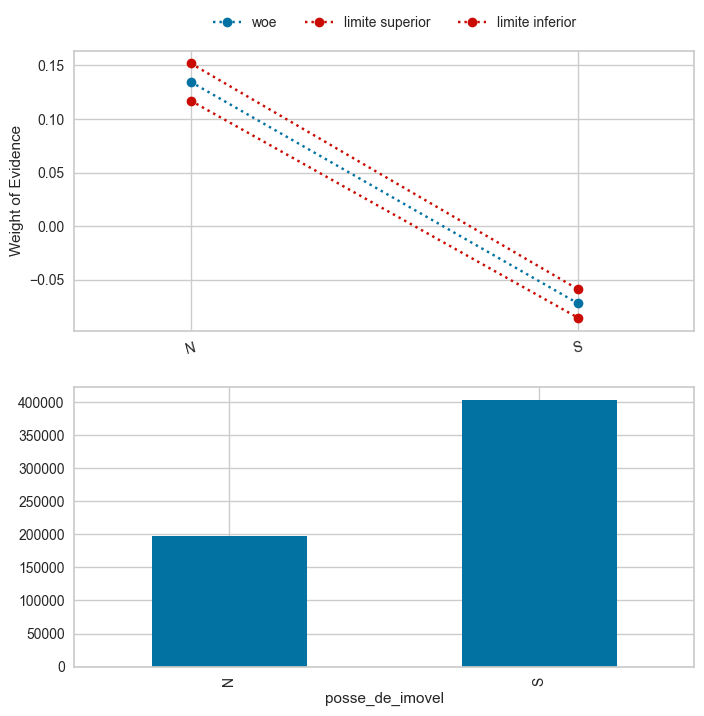

In [25]:

# Realizando o cálculo para a variável 'posse_de_imovel'
biv_discreta('posse_de_imovel', df_metadados)

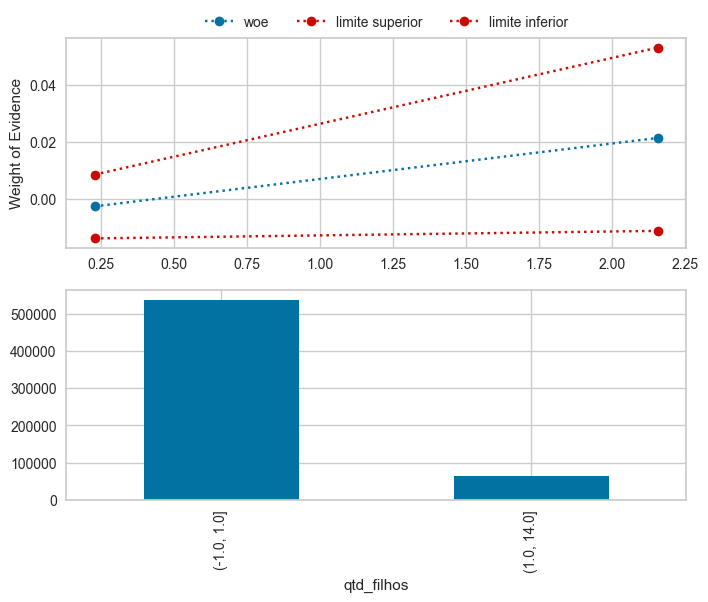

In [26]:

# Realizando o cálculo para a variável 'qtd_filhos'
biv_continua('qtd_filhos', 5, df_metadados)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Bolsista,279,12,0.041237,Bolsista,291,0.011656,0.064178,0.018296,-3.146305,-2.679758,-3.982616,-0.413614,0.052933,-1.249925
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Servidor público,49651,2330,0.044824,Servidor público,51981,0.000908,0.046603,0.043045,-3.059150,-3.018369,-3.101504,-0.326459,-0.285678,-0.368813


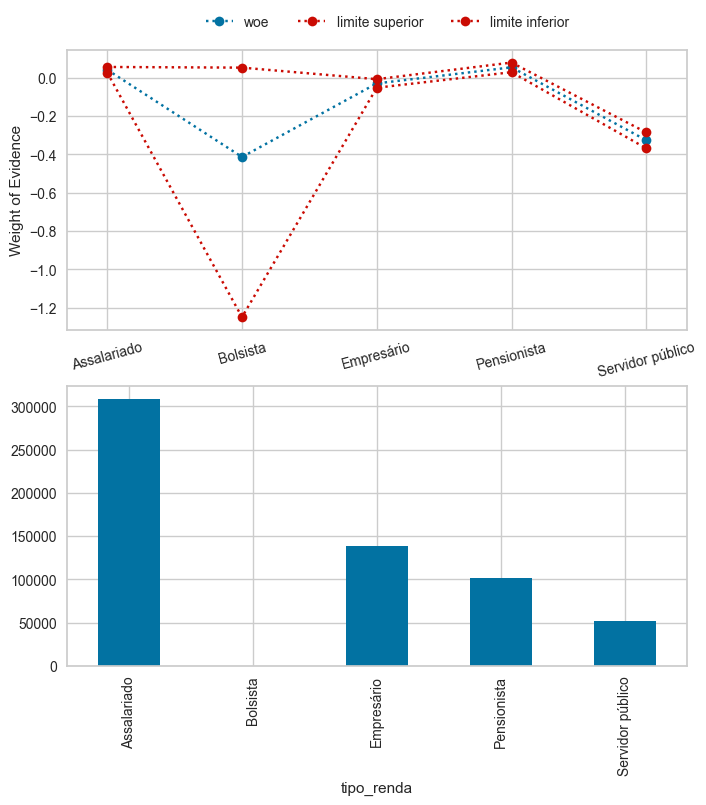

In [27]:

# Realizando o cálculo para a variável 'tipo_renda'
biv_discreta('tipo_renda', df_metadados)

,qt_bom,qt_mau,mau,tipo_renda,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_renda,,,,,,,,,,,,,,
Assalariado,288865,19595,0.063525,Assalariado,308460,0.000439,0.064386,0.062665,-2.690685,-2.676307,-2.705246,0.042006,0.056384,0.027445
Empresário,129935,8206,0.059403,Empresário,138141,0.000636,0.060650,0.058157,-2.762169,-2.740076,-2.784700,-0.029478,-0.007385,-0.052009
Pensionista,94627,6500,0.064276,Pensionista,101127,0.000771,0.065787,0.062764,-2.678141,-2.653280,-2.703552,0.054550,0.079411,0.029139
Serv._Publ./Bolsista,49930,2342,0.044804,Serv._Publ./Bolsista,52272,0.000905,0.046578,0.043031,-3.059617,-3.018938,-3.101860,-0.326926,-0.286247,-0.369169


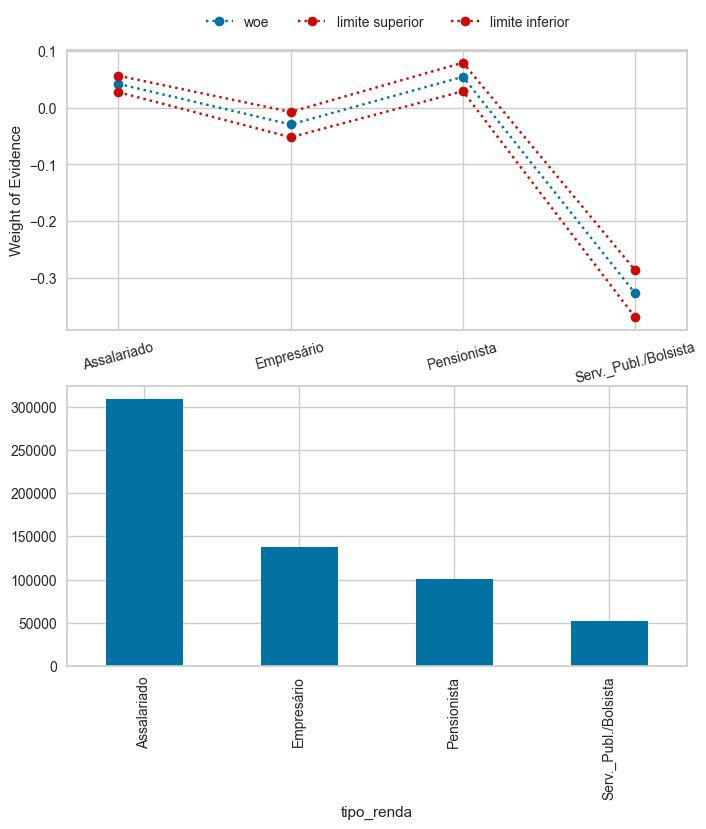

In [28]:

# Ajustando as categorias (juntando Bolsista a Servidor Público)
df_metadados2 = df_metadados.copy()
df_metadados2['tipo_renda'] = df_metadados2.tipo_renda.replace({'Bolsista':'Serv._Publ./Bolsista', 'Servidor público': 'Serv._Publ./Bolsista'})
biv_discreta('tipo_renda', df_metadados2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fundamental,6420,481,0.069700,Fundamental,6901,0.003065,0.075709,0.063691,-2.591306,-2.502130,-2.687900,0.141385,0.230561,0.044791
Médio,379939,25510,0.062918,Médio,405449,0.000381,0.063665,0.062170,-2.700940,-2.688333,-2.713688,0.031751,0.044358,0.019003
Pós graduação,608,43,0.066052,Pós graduação,651,0.009735,0.085167,0.046937,-2.648975,-2.374126,-3.010867,0.083716,0.358565,-0.278176
Superior completo,154354,9086,0.055592,Superior completo,163440,0.000567,0.056703,0.054481,-2.832514,-2.811552,-2.853874,-0.099823,-0.078861,-0.121183
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


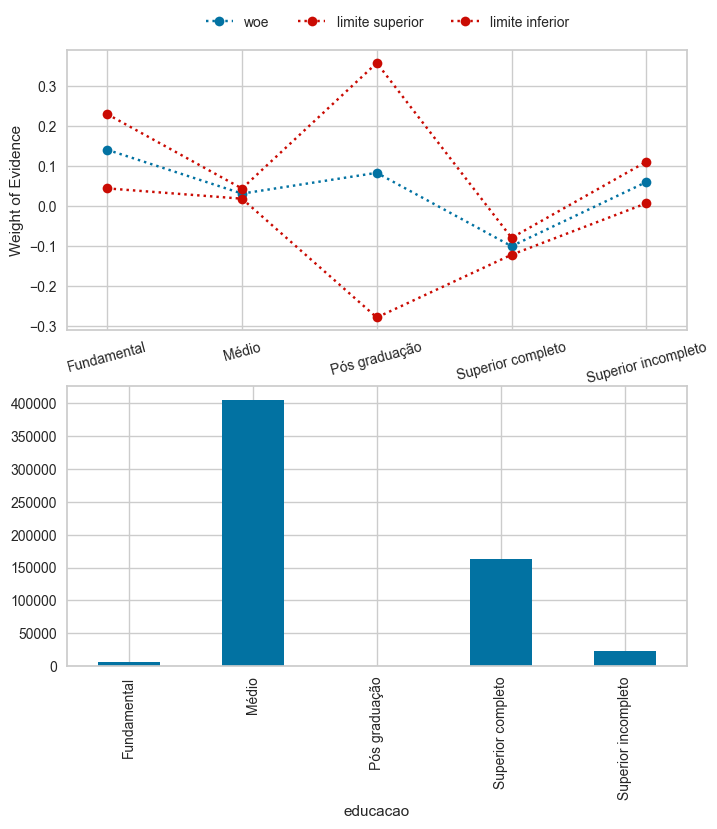

In [29]:
# Realizando o cálculo para a variável 'educacao'
biv_discreta('educacao', df_metadados2)

,qt_bom,qt_mau,mau,educacao,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
educacao,,,,,,,,,,,,,,
Fund./Medio,386359,25991,0.063031,Fund./Medio,412350,0.000378,0.063773,0.062290,-2.699017,-2.686525,-2.711646,0.033674,0.046166,0.021045
Pos./Sup. Completo,154962,9129,0.055634,Pos./Sup. Completo,164091,0.000566,0.056743,0.054525,-2.831724,-2.810810,-2.853034,-0.099033,-0.078119,-0.120342
Superior incompleto,22036,1523,0.064646,Superior incompleto,23559,0.001602,0.067786,0.061506,-2.671995,-2.621201,-2.725141,0.060696,0.111490,0.007550


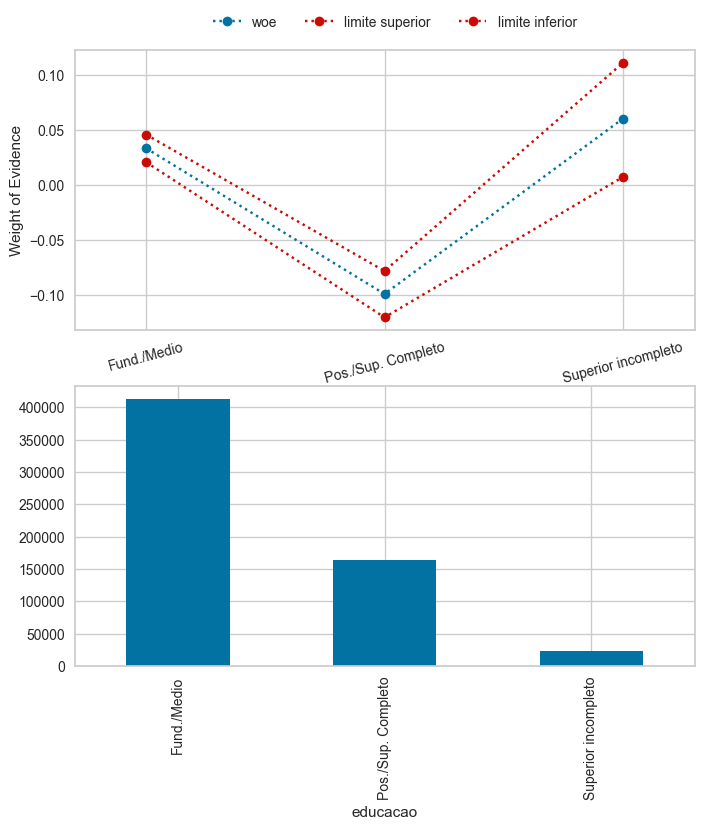

In [30]:
# Ajustando as categorias (juntando Fundamental a Médio e Pós graduação a Superior completo)
df_metadados2['educacao'] = df_metadados2.educacao.replace({'Fundamental':'Fund./Medio', 'Médio': 'Fund./Medio',
                                                           'Pós graduação': 'Pos./Sup. Completo', 'Superior completo': 'Pos./Sup. Completo'})
biv_discreta('educacao', df_metadados2)

,qt_bom,qt_mau,mau,estado_civil,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
estado_civil,,,,,,,,,,,,,,
Casado,395880,25269,0.060000,Casado,421149,0.000366,0.060717,0.059283,-2.751533,-2.738886,-2.764322,-0.018842,-0.006195,-0.031631
Separado,31994,2194,0.064175,Separado,34188,0.001325,0.066772,0.061577,-2.679822,-2.637360,-2.723916,0.052869,0.095331,0.008775
Solteiro,68585,4636,0.063315,Solteiro,73221,0.000900,0.065079,0.061551,-2.694222,-2.664858,-2.724359,0.038469,0.067833,0.008332
União,43048,3060,0.066366,União,46108,0.001159,0.068638,0.064094,-2.643901,-2.607801,-2.681168,0.088790,0.124890,0.051523
Viúvo,23850,1484,0.058577,Viúvo,25334,0.001475,0.061469,0.055686,-2.777043,-2.725779,-2.830738,-0.044352,0.006912,-0.098047


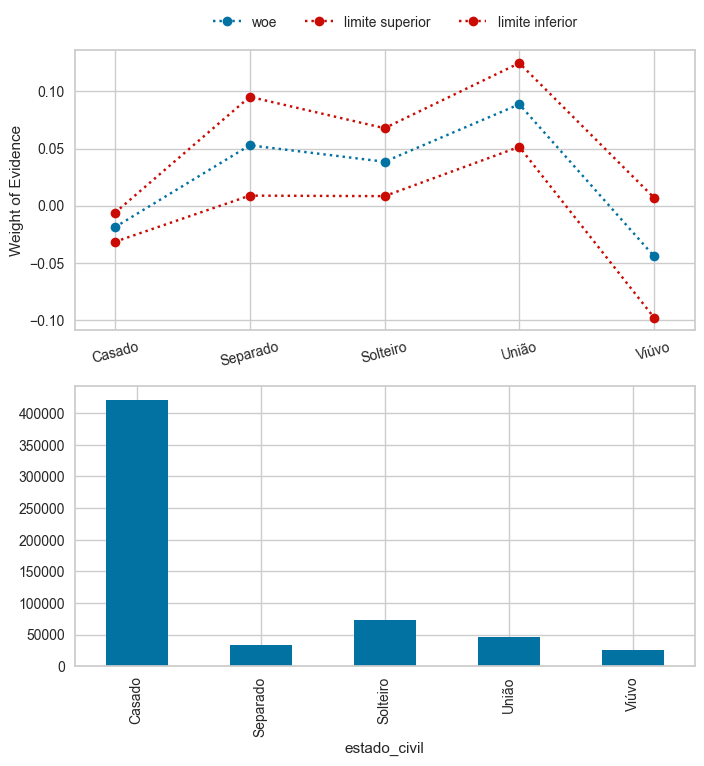

In [31]:

# Realizando o cálculo para a variável 'estado_civil'
biv_discreta('estado_civil', df_metadados2)

,qt_bom,qt_mau,mau,tipo_residencia,cont,ep,mau_sup,mau_inf,logit,logit_sup,logit_inf,woe,woe_sup,woe_inf
tipo_residencia,,,,,,,,,,,,,,
Aluguel,7666,596,0.072137,Aluguel,8262,0.002846,0.077717,0.066558,-2.554310,-2.473779,-2.640804,0.178382,0.258912,0.091887
Casa,506887,32449,0.060165,Casa,539336,0.000324,0.060799,0.059530,-2.748618,-2.737450,-2.759898,-0.015927,-0.004759,-0.027207
Com os pais,24733,1997,0.074710,Com os pais,26730,0.001608,0.077862,0.071558,-2.516492,-2.471755,-2.563000,0.216199,0.260936,0.169691
Comunitário,2449,185,0.070235,Comunitário,2634,0.004979,0.079999,0.060472,-2.583079,-2.442363,-2.743199,0.149612,0.290329,-0.010508
Estúdio,4071,225,0.052374,Estúdio,4296,0.003399,0.059038,0.045711,-2.895544,-2.768721,-3.038637,-0.162852,-0.036030,-0.305946
Governamental,17551,1191,0.063547,Governamental,18742,0.001782,0.067040,0.060054,-2.690318,-2.633076,-2.750571,0.042373,0.099615,-0.017880


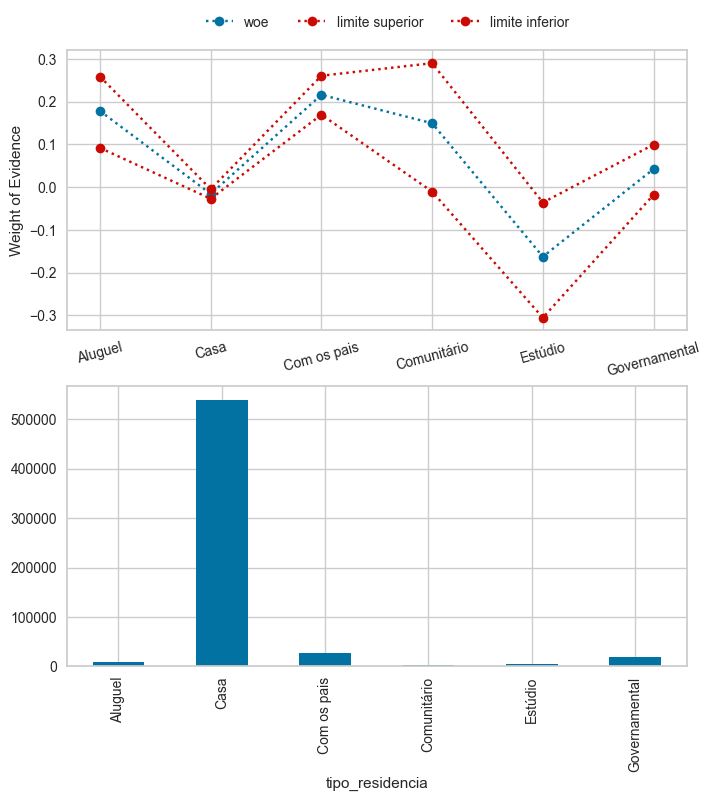

In [32]:
# Realizando o cálculo para a variável 'tipo_residencia'
biv_discreta('tipo_residencia', df_metadados2)

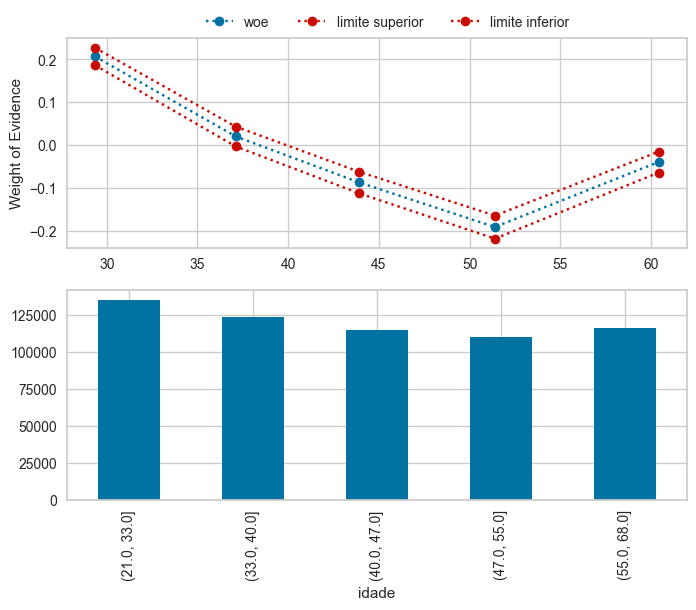

In [33]:
# Realizando o cálculo para a variável 'idade'
biv_continua('idade', 5, df_metadados2)

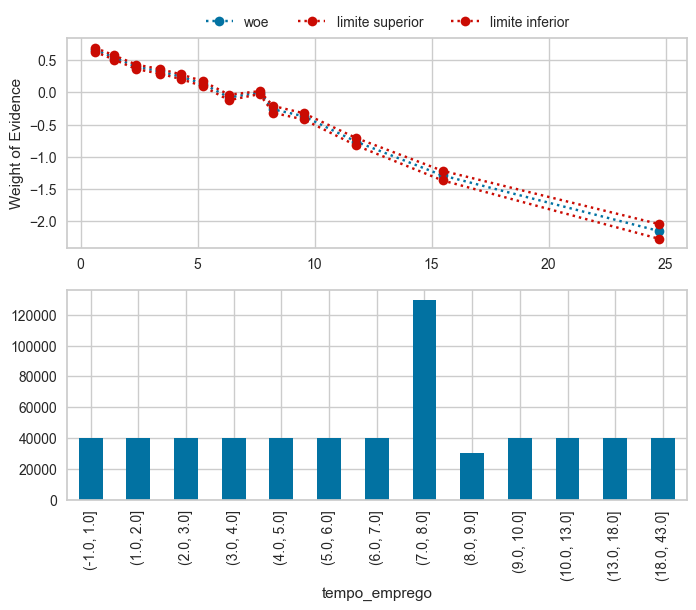

In [34]:
# Realizando o cálculo para a variável 'tempo_emprego'
biv_continua('tempo_emprego', 15, df_metadados2)

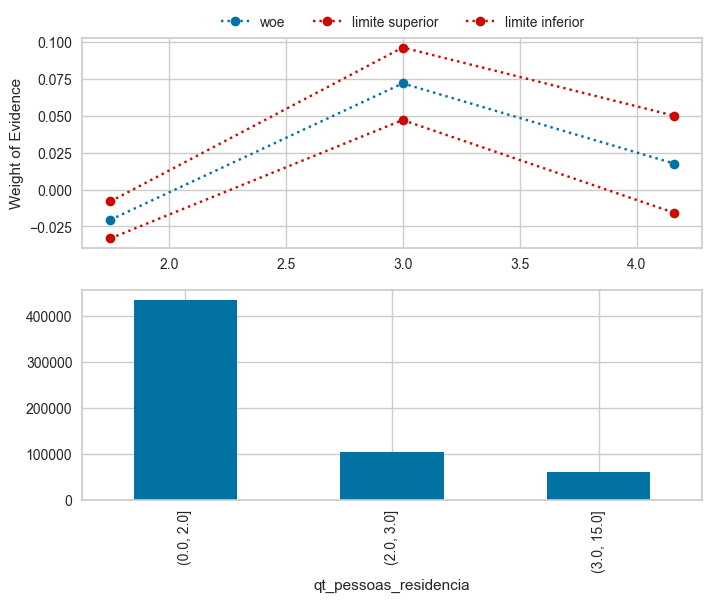

In [35]:
# Realizando o cálculo para a variável 'qt_pessoas_residencia'
biv_continua('qt_pessoas_residencia', 5, df_metadados2)

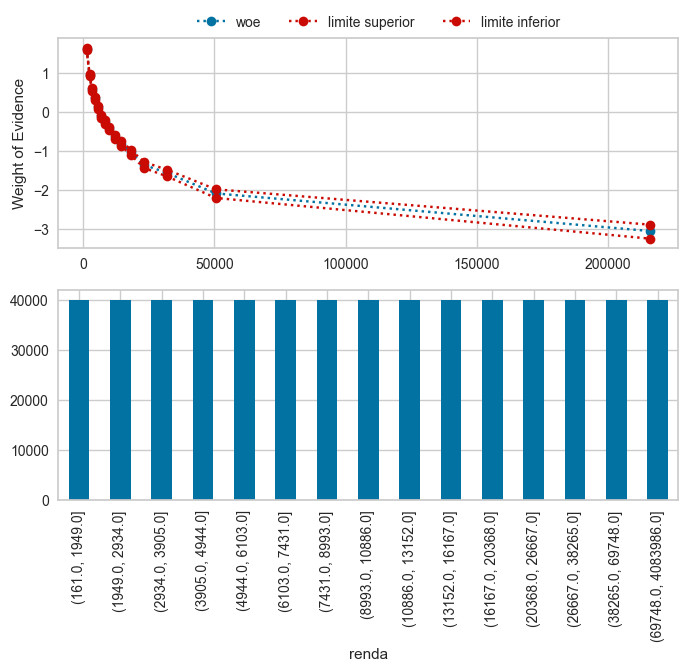

In [36]:
# Realizando o cálculo para a variável 'renda'
biv_continua('renda', 15, df_metadados2)

In [37]:

# ajuda para definir a equação da regressão
' + '.join(list(df_metadados2.columns))

'sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + bom'

In [38]:
# Desenvolvendo o modelo
formula = '''
    mau ~ sexo + posse_de_veiculo + posse_de_imovel + qtd_filhos + tipo_renda + educacao + 
    estado_civil + tipo_residencia + idade + tempo_emprego + qt_pessoas_residencia + renda
'''

rl = smf.glm(formula, data=df_metadados2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599977
Model Family:                Binomial   Df Model:                           22
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2488e+05
Date:                Fri, 21 Jun 2024   Deviance:                   2.4965e+05
Time:                        18:49:31   Pearson chi2:                 1.58e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04261
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.1602      0.186     -6.225      0.000      -1.526      -0.795
sexo[T.M]                             -0.1262      0.013     -9.617      0.000      -0.152      -0.101
posse_de_veiculo[T.S]                  0.0318      0.012      2.572      0.010       0.008       0.056
posse_de_imovel[T.S]                  -0.0853      0.012     -7.227      0.000      -0.108      -0.062
tipo_renda[T.Empresário]              -0.0532      0.014     -3.795      0.000      -0.081      -0.026
tipo_renda[T.Pensionista]             -0.0394      0.020     -1.946      0.052      -0.079       0.000
tipo_renda[T.Serv._Publ./Bolsista]    -0.0312      0.023     -1.347      0.178      -0.077       0.014
educacao[T.Pos./Sup. Completo]        -0.0603      0.013     -4.547      0.000      -0.086      -0.034
educacao[T.Superior incompleto]       -0.0502      0.028     -1.774      0.076      -0.106       0.005
estado_civil[T.Separado]              -0.0861      0.092     -0.931      0.352      -0.267       0.095
estado_civil[T.Solteiro]              -0.1164      0.090     -1.286      0.198      -0.294       0.061
estado_civil[T.União]                  0.0475      0.020      2.335      0.020       0.008       0.087
estado_civil[T.Viúvo]                 -0.1578      0.094     -1.678      0.093      -0.342       0.026
tipo_residencia[T.Casa]               -0.0891      0.044     -2.023      0.043      -0.175      -0.003
tipo_residencia[T.Com os pais]        -0.0739      0.050     -1.492      0.136      -0.171       0.023
tipo_residencia[T.Comunitário]        -0.1369      0.089     -1.534      0.125      -0.312       0.038
tipo_residencia[T.Estúdio]            -0.0339      0.082     -0.411      0.681      -0.195       0.128
tipo_residencia[T.Governamental]      -0.0861      0.053     -1.614      0.107      -0.191       0.018
qtd_filhos                             0.1268      0.090      1.416      0.157      -0.049       0.302
idade                                  0.0001      0.001      0.146      0.884      -0.001       0.001
tempo_emprego                         -0.0237      0.002    -13.136      0.000      -0.027      -0.020
qt_pessoas_residencia                 -0.1237      0.089     -1.384      0.166      -0.299       0.051
renda                                 -0.0001   1.09e-06    -93.641      0.000      -0.000   -9.95e-05
======================================================================================================
"""

In [39]:
# Ordenando o metadados pelo IV
metadados.sort_values(by='IV', ascending=False)

,dtype,nmissing,valores_unicos,papel,IV
renda,float64,0.0,112472.0,covariavel,0.959826
tempo_emprego,float64,0.0,3005.0,covariavel,0.283956
idade,int64,0.0,47.0,covariavel,0.018434
tipo_renda,object,0.0,5.0,covariavel,0.009718
posse_de_imovel,object,0.0,2.0,covariavel,0.009690
educacao,object,0.0,5.0,covariavel,0.003690
tipo_residencia,object,0.0,6.0,covariavel,0.003330
sexo,object,0.0,2.0,covariavel,0.002665
estado_civil,object,0.0,5.0,covariavel,0.001305
qt_pessoas_residencia,float64,0.0,9.0,covariavel,0.001263


In [40]:
# Refazendo o modelo com IV acima de 0.009, retirando idade que não está representativo
formula = '''
    mau ~ posse_de_imovel + tipo_renda + tempo_emprego + renda
'''

rl = smf.glm(formula, data=df_metadados2, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               600000
Model:                            GLM   Df Residuals:                   599993
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2495e+05
Date:                Fri, 21 Jun 2024   Deviance:                   2.4977e+05
Time:                        18:49:43   Pearson chi2:                 1.67e+16
No. Iterations:                    11   Pseudo R-squ. (CS):            0.04240
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                             -1.5321      0.013   -114.208      0.000      -1.558      -1.506
posse_de_imovel[T.S]                  -0.0815      0.011     -7.100      0.000      -0.104      -0.059
tipo_renda[T.Empresário]              -0.0515      0.014     -3.716      0.000      -0.079      -0.024
tipo_renda[T.Pensionista]             -0.0170      0.016     -1.061      0.288      -0.048       0.014
tipo_renda[T.Serv._Publ./Bolsista]    -0.0383      0.023     -1.664      0.096      -0.083       0.007
tempo_emprego                         -0.0228      0.002    -12.803      0.000      -0.026      -0.019
renda                                 -0.0001   1.08e-06    -94.868      0.000      -0.000      -0.000
======================================================================================================
"""

## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [41]:
# Avaliando na base de desenvolvimento
df_metadados2['score'] = rl.predict(df_metadados2)

# Acurácia
acc = metrics.accuracy_score(df_metadados2.mau, df_metadados2.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_metadados2.mau, df_metadados2.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_metadados2.loc[df_metadados2.mau == 1, 'score'], df_metadados2.loc[df_metadados2.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 59.2% 
AUC: 76.7% 
GINI: 53.4%
KS: 39.5%




<span style="color:blue; font-size:20px">Conclusão para a base de desenvolvimento:</span>

<font color='blue'>- A Acurácia indica que aproximadamente 59.2% das previsões do seu modelo estão corretas;</font>

<font color='blue'>- O AUC indica que o modelo tem um bom poder discriminativo;</font>

<font color='blue'>- O GINI também sugere que o modelo está razoavelmente bom em separar as classes; e</font>

<font color='blue'>- O KS indica que há uma diferença significativa entre essas distribuições.</font> 

In [42]:
# Ajustando a base *out of time*
df_validacao = df_validacao.drop(columns = ['data_ref', 'index'])
media = df_validacao['tempo_emprego'].mean()
df_validacao['tempo_emprego'] = df_validacao['tempo_emprego'].copy().fillna(media)
df_validacao['tipo_renda'] = df_validacao.tipo_renda.replace({'Bolsista':'Serv._Publ./Bolsista', 
                                                              'Servidor público': 'Serv._Publ./Bolsista'})
df_validacao['educacao'] = df_validacao.educacao.replace({'Fundamental':'Fund./Medio', 'Médio': 'Fund./Medio',
                                                           'Pós graduação': 'Pos./Sup. Completo', 
                                                          'Superior completo': 'Pos./Sup. Completo'})
df_validacao.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150000 entries, 633328 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   150000 non-null  object 
 1   posse_de_veiculo       150000 non-null  object 
 2   posse_de_imovel        150000 non-null  object 
 3   qtd_filhos             150000 non-null  int64  
 4   tipo_renda             150000 non-null  object 
 5   educacao               150000 non-null  object 
 6   estado_civil           150000 non-null  object 
 7   tipo_residencia        150000 non-null  object 
 8   idade                  150000 non-null  int64  
 9   tempo_emprego          150000 non-null  float64
 10  qt_pessoas_residencia  150000 non-null  float64
 11  renda                  150000 non-null  float64
 12  mau                    150000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 16.0+ MB


In [43]:
# Avaliando na base *out of time*
df_validacao['score'] = rl.predict(df_validacao)

# Acurácia
acc = metrics.accuracy_score(df_validacao.mau, df_validacao.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_validacao.mau, df_validacao.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_validacao.loc[df_validacao.mau == 1, 'score'], df_validacao.loc[df_validacao.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 32.1% 
AUC: 72.6% 
GINI: 45.3%
KS: 33.2%


<span style="color:blue; font-size:20px">Conclusão para a base de validação:</span>

<font color='blue'>Houve queda em todos os indicadores abaixo para a base de validação:</font>

<font color='blue'>- A Acurácia indica que aproximadamente 32.1% das previsões do seu modelo estão corretas;</font>

<font color='blue'>- O AUC indica que o modelo tem um poder discriminativo razoável;</font>

<font color='blue'>- O GINI também sugere que o modelo está razoavelmente bom em separar as classes; e</font>

<font color='blue'>- O KS indica que há alguma separação entre as distribuições, mas não é muito significativa.</font> 

# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [44]:
# Visualizando a estrutura da base de dados e identificando que há valores nulos na variável 'tempo_emprego'
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  float64  

In [45]:
df = df.drop(columns=['data_ref','index'])
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,0
33328,M,S,S,1,Assalariado,Médio,Casado,Casa,41,8.134247,3.0,4979.48,0
33329,F,N,N,0,Assalariado,Superior completo,Solteiro,Casa,26,1.424658,1.0,1285.25,0
33330,M,N,S,1,Assalariado,Superior incompleto,Casado,Casa,37,15.449315,3.0,14473.15,0
33331,F,N,S,1,Assalariado,Médio,Casado,Casa,30,0.369863,3.0,1366.63,0


In [46]:
# Tratando valores missing: média para variável numérica e moda para variável categórica
def valores_missing(df):
    for coluna in df.columns:
        if df[coluna].isnull().sum() > 0:
            if df[coluna].dtype in [np.float64, np.int64]:
                df[coluna] = df[coluna].fillna(df[coluna].mean())
            else:
                df[coluna] = df[coluna].fillna(df[coluna].mode()[0])
    return df

In [47]:
# Executando a função 'valores_missing'
df_missing = valores_missing(df)
df_missing.info()

<class 'pandas.core.frame.DataFrame'>
Index: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          750000 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  int64  
dtypes: float64(3), int64(3), object(7)
memory usage: 80.1+ MB


### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [48]:
# Visualizando dados estatísticos
df_missing.describe()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
count,750000.000000,750000.000000,750000.000000,750000.000000,7.500000e+05,750000.000000
mean,0.433251,43.804733,7.748574,2.212241,2.323854e+04,0.078191
std,0.739379,11.229868,6.100107,0.903428,7.910601e+04,0.268472
min,0.000000,22.000000,0.117808,1.000000,1.076700e+02,0.000000
25%,0.000000,34.000000,3.635616,2.000000,3.467700e+03,0.000000
50%,0.000000,43.000000,7.473973,2.000000,7.861820e+03,0.000000
75%,1.000000,53.000000,9.090411,3.000000,1.831828e+04,0.000000
max,14.000000,68.000000,42.906849,15.000000,4.083986e+06,1.000000


Os valores máximos de algumas variáveis estão bem discrepantes da média, sinalizando a presença de outliers.

In [49]:
# Buscando  e excluíndo valores discrepantes com o 'IsolationForest'
def remover_outlier(df):
    # Selecionar apenas as colunas numéricas
    df_num = df.select_dtypes(include='number')
    X = df_num.iloc[:, :-1]
    y = df_num.iloc[:, -1]

    # Detectar outliers usando Isolation Forest
    iso = IsolationForest(contamination=0.1, random_state=42)
    yhat = iso.fit_predict(X)
    mask = yhat != -1

    # Filtrar os dados sem outliers
    X_sem_outliers = X[mask]
    y_sem_outliers = y[mask]

    # Reconstruir o DataFrame original
    df_outlier = df.copy()
    df_outlier.loc[df_num.index, X.columns] = X_sem_outliers
    df_outlier.loc[df_num.index, y.name] = y_sem_outliers
    df_outlier.dropna(inplace=True)

    return df_outlier

In [50]:
# Executando a função 'remover_outlier' e visualizando o novo dataframe
df_final = remover_outlier(df)
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 675004 entries, 0 to 716648
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   675004 non-null  object 
 1   posse_de_veiculo       675004 non-null  object 
 2   posse_de_imovel        675004 non-null  object 
 3   qtd_filhos             675004 non-null  float64
 4   tipo_renda             675004 non-null  object 
 5   educacao               675004 non-null  object 
 6   estado_civil           675004 non-null  object 
 7   tipo_residencia        675004 non-null  object 
 8   idade                  675004 non-null  float64
 9   tempo_emprego          675004 non-null  float64
 10  qt_pessoas_residencia  675004 non-null  float64
 11  renda                  675004 non-null  float64
 12  mau                    675004 non-null  float64
dtypes: float64(6), object(7)
memory usage: 72.1+ MB


### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [51]:
# Treinar o modelo de regressão logística
X = df_final.iloc[:, :-1]
y = df_final.iloc[:, -1]
categorical_cols = df_final.select_dtypes(include=['object']).columns
X = pd.get_dummies(X, columns=categorical_cols)
model = LogisticRegression(solver='liblinear', max_iter=5000)
model.fit(X, y)

LogisticRegression(max_iter=5000, solver='liblinear')

In [52]:
# Obter os coeficientes das variáveis
coefficients = model.coef_[0]

In [53]:
# Calcular a importância relativa das variáveis
importance = np.abs(coefficients) * np.std(X, 0)

In [54]:
# Criar um DataFrame com as variáveis e suas importâncias
df_importance = pd.DataFrame(importance).reset_index()
df_importance.columns = ['Variável', 'Importância']
df_importance = df_importance.sort_values(by='Importância', ascending=False)
df_importance.head(10)

,Variável,Importância
4,renda,2.926080
1,idade,0.305360
2,tempo_emprego,0.013764
3,qt_pessoas_residencia,0.001213
21,estado_civil_Casado,0.000220
17,educacao_Médio,0.000212
5,sexo_F,0.000209
10,posse_de_imovel_S,0.000206
0,qtd_filhos,0.000204
7,posse_de_veiculo_N,0.000202


### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [55]:
# Criando função para a realização do PCA para 5 componentes
def pca(df):
    X = df.iloc[:, :-1]
    categorical_cols = df.select_dtypes(include=['object']).columns
    X = pd.get_dummies(X, columns=categorical_cols)
    pca = PCA(n_components=5)
    pca.fit(X)
    X_pca = pca.transform(X)
    return X_pca

In [56]:
# Visualizando novo DataFrame
X_pca = pca(df_final)
df_pca = pd.DataFrame(data=X_pca)
df_pca.head()

,0,1,2,3,4
0,-10153.009207,-0.112081,1.454755,-1.696119,-0.268951
1,-7688.919192,-2.258276,2.570420,1.389317,0.836317
2,-11383.150931,-17.446630,-2.280414,-2.165579,-0.285663
3,1804.751432,-6.256395,9.022158,0.943631,-0.097970
4,-11301.770836,-13.608882,-3.697333,0.444171,-1.174175


### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [57]:
#Função para aplicar o get_dummies para transformar columas catégoricas do dataframe
def criar_dummies(df):
    df_dummies = pd.get_dummies(df, drop_first=True, dtype='int64')
    return df_dummies

In [58]:
# Executando função 'criar_dummies' e Visualizando DataFrame
df_dummies = criar_dummies(df_final)
df_dummies.head()

,qtd_filhos,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,sexo_M,posse_de_veiculo_S,posse_de_imovel_S,tipo_renda_Bolsista,...,educacao_Superior incompleto,estado_civil_Separado,estado_civil_Solteiro,estado_civil_União,estado_civil_Viúvo,tipo_residencia_Casa,tipo_residencia_Com os pais,tipo_residencia_Comunitário,tipo_residencia_Estúdio,tipo_residencia_Governamental
0,0.0,43.0,6.873973,1.0,2515.39,0.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
33328,1.0,41.0,8.134247,3.0,4979.48,0.0,1,1,1,0,...,0,0,0,0,0,1,0,0,0,0
33329,0.0,26.0,1.424658,1.0,1285.25,0.0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
33330,1.0,37.0,15.449315,3.0,14473.15,0.0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
33331,1.0,30.0,0.369863,3.0,1366.63,0.0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0


### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [59]:
# Criando um pipeline
valores_missing = valores_missing(df)
remover_outlier = remover_outlier(valores_missing)
pca = pca(remover_outlier)
criar_dummies = criar_dummies(remover_outlier)
pipe = Pipeline(steps=[
    ("substituicao_de_nulos", valores_missing),
    ("remocao_outliers", remover_outlier),
    ("pca", pca),
    ("criacao_de_dummy", criar_dummies)
])

In [60]:
# Visualizando funções
pipe.named_steps

{'substituicao_de_nulos':        sexo posse_de_veiculo posse_de_imovel  qtd_filhos   tipo_renda  \
 0         F                N               N           0   Empresário   
 33328     M                S               S           1  Assalariado   
 33329     F                N               N           0  Assalariado   
 33330     M                N               S           1  Assalariado   
 33331     F                N               S           1  Assalariado   
 ...     ...              ...             ...         ...          ...   
 716668    F                S               S           0   Empresário   
 716669    F                N               N           0  Assalariado   
 716670    M                N               S           0   Empresário   
 716648    M                N               N           1  Assalariado   
 749999    M                S               N           2  Assalariado   
 
                    educacao estado_civil tipo_residencia  idade  \
 0               

### Treinar um modelo de regressão logistica com o resultado

In [61]:
# Separando os dados em conjuntos de treino e teste
df_dummies = pipe.named_steps['criacao_de_dummy']
# Ajustando as colunas
df_dummies.columns = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau', 'sexo_M', 'posse_de_veiculo_S', 'posse_de_imovel_S',
       'tipo_renda_Bolsista', 'tipo_renda_Empresário',
       'tipo_renda_Pensionista', 'tipo_renda_Servidor_público',
       'educacao_Médio', 'educacao_Pós_graduação',
       'educacao_Superior_completo', 'educacao_Superior_incompleto',
       'estado_civil_Separado', 'estado_civil_Solteiro', 'estado_civil_União',
       'estado_civil_Viúvo', 'tipo_residencia_Casa',
       'tipo_residencia_Com_os_pais', 'tipo_residencia_Comunitário',
       'tipo_residencia_Estúdio', 'tipo_residencia_Governamental']
X = df_dummies.drop('mau', axis=1)  # Removendo a coluna alvo dos dados de entrada
y = df_dummies['mau']  # Dados alvo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

In [62]:
# Ajustando as colunas para definir a equação da regressão
' + '.join(list(df_dummies.columns))

'qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + renda + mau + sexo_M + posse_de_veiculo_S + posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + educacao_Médio + educacao_Pós_graduação + educacao_Superior_completo + educacao_Superior_incompleto + estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Casa + tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental'

In [63]:
# Desenvolvendo o modelo
formula = '''
    mau ~ qtd_filhos + idade + tempo_emprego + qt_pessoas_residencia + renda + sexo_M + posse_de_veiculo_S + 
    posse_de_imovel_S + tipo_renda_Bolsista + tipo_renda_Empresário + tipo_renda_Pensionista + tipo_renda_Servidor_público + 
    educacao_Médio + educacao_Pós_graduação + educacao_Superior_completo + educacao_Superior_incompleto + 
    estado_civil_Separado + estado_civil_Solteiro + estado_civil_União + estado_civil_Viúvo + tipo_residencia_Casa + 
    tipo_residencia_Com_os_pais + tipo_residencia_Comunitário + tipo_residencia_Estúdio + tipo_residencia_Governamental
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               540003
Model:                            GLM   Df Residuals:                   539977
Model Family:                Binomial   Df Model:                           25
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3992e+05
Date:                Fri, 21 Jun 2024   Deviance:                   2.7983e+05
Time:                        18:51:13   Pearson chi2:                 7.41e+09
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05596
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        -0.8598      0.177     -4.847      0.000      -1.208      -0.512
qtd_filhos                        0.0420      0.083      0.508      0.611      -0.120       0.204
idade                            -0.0004      0.001     -0.629      0.530      -0.002       0.001
tempo_emprego                    -0.0244      0.002    -14.496      0.000      -0.028      -0.021
qt_pessoas_residencia            -0.0610      0.082     -0.740      0.459      -0.223       0.101
renda                            -0.0001   1.31e-06   -110.382      0.000      -0.000      -0.000
sexo_M                           -0.1183      0.012     -9.819      0.000      -0.142      -0.095
posse_de_veiculo_S                0.0337      0.011      2.964      0.003       0.011       0.056
posse_de_imovel_S                -0.0823      0.011     -7.597      0.000      -0.104      -0.061
tipo_renda_Bolsista              -0.1524      0.301     -0.507      0.612      -0.742       0.437
tipo_renda_Empresário            -0.0482      0.013     -3.753      0.000      -0.073      -0.023
tipo_renda_Pensionista           -0.0138      0.018     -0.752      0.452      -0.050       0.022
tipo_renda_Servidor_público      -0.0248      0.021     -1.156      0.248      -0.067       0.017
educacao_Médio                   -0.0672      0.044     -1.526      0.127      -0.153       0.019
educacao_Pós_graduação           -0.2700      0.161     -1.679      0.093      -0.585       0.045
educacao_Superior_completo       -0.1136      0.045     -2.527      0.012      -0.202      -0.025
educacao_Superior_incompleto     -0.1056      0.051     -2.088      0.037      -0.205      -0.006
estado_civil_Separado            -0.0186      0.085     -0.218      0.828      -0.186       0.148
estado_civil_Solteiro            -0.0611      0.083     -0.732      0.464      -0.225       0.102
estado_civil_União                0.0282      0.019      1.515      0.130      -0.008       0.065
estado_civil_Viúvo               -0.1153      0.087     -1.330      0.183      -0.285       0.055
tipo_residencia_Casa             -0.0784      0.040     -1.956      0.050      -0.157       0.000
tipo_residencia_Com_os_pais      -0.0577      0.045     -1.277      0.202      -0.146       0.031
tipo_residencia_Comunitário      -0.1978      0.084     -2.345      0.019      -0.363      -0.033
tipo_residencia_Estúdio          -0.0652      0.076     -0.853      0.394      -0.215       0.085
tipo_residencia_Governamental    -0.0417      0.048     -0.862      0.389      -0.137       0.053
=================================================================================================
"""

In [64]:
# Desenvolvendo o modelo com as variáveis mais importantes
formula = '''
    mau ~ tempo_emprego + renda + sexo_M + posse_de_veiculo_S + posse_de_imovel_S + tipo_renda_Empresário + 
    educacao_Superior_completo
'''

rl = smf.glm(formula, data=df_train, family=sm.families.Binomial()).fit()

rl.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                    mau   No. Observations:               540003
Model:                            GLM   Df Residuals:                   539995
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.3993e+05
Date:                Fri, 21 Jun 2024   Deviance:                   2.7987e+05
Time:                        18:51:16   Pearson chi2:                 7.48e+09
No. Iterations:                     8   Pseudo R-squ. (CS):            0.05590
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -1.1452      0.014    -83.847      0.000      -1.172      -1.118
tempo_emprego                 -0.0252      0.002    -16.023      0.000      -0.028      -0.022
renda                         -0.0001    1.3e-06   -110.661      0.000      -0.000      -0.000
sexo_M                        -0.1137      0.012     -9.617      0.000      -0.137      -0.090
posse_de_veiculo_S             0.0306      0.011      2.736      0.006       0.009       0.053
posse_de_imovel_S             -0.0888      0.010     -8.464      0.000      -0.109      -0.068
tipo_renda_Empresário         -0.0415      0.012     -3.388      0.001      -0.066      -0.018
educacao_Superior_completo    -0.0465      0.012     -3.958      0.000      -0.070      -0.023
==============================================================================================
"""

In [65]:
# Avaliando na base de treino
df_train['score'] = rl.predict(df_train)

# Acurácia
acc = metrics.accuracy_score(df_train.mau, df_train.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_train.mau, df_train.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_train.loc[df_train.mau == 1, 'score'], df_train.loc[df_train.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 50.5% 
AUC: 76.3% 
GINI: 52.7%
KS: 39.4%


In [66]:
# Avaliando na base de teste
df_test['score'] = rl.predict(df_test)

# Acurácia
acc = metrics.accuracy_score(df_test.mau, df_test.score> 0.068)
#AUC
fpr, tpr, thresholds = metrics.roc_curve(df_test.mau, df_test.score)
auc = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc -1
ks = ks_2samp(df_test.loc[df_test.mau == 1, 'score'], df_test.loc[df_test.mau != 1, 'score']).statistic

print('Acurácia: {0:.1%} \nAUC: {1:.1%} \nGINI: {2:.1%}\nKS: {3:.1%}'
      .format(acc, auc, gini, ks))

Acurácia: 50.6% 
AUC: 76.9% 
GINI: 53.8%
KS: 40.3%


O novo modelo desenvolvido apresentou acurária inferior ao modelo inicial (59.2%), contudo, registrou melhor generalização tendo em vista que o resultado do modelo na base de teste foi semelhante ao desempenho do modelo na base de treino, diferente do modelo inicial que apresentou queda significativa quando foi realizado na base de validação (32.1%).

### Salvar o pickle file do modelo treinado

In [67]:
# Salvando o modelo 
nome_arquivo = 'rl_model_final.pkl'
pickle.dump(rl, open(nome_arquivo, 'wb'))

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [68]:
import pandas as pd

df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [69]:
df.drop(['data_ref','index'], axis=1, inplace=True)
df.head()

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [70]:
# Separando uma parte dos dados para validação
data = df.sample(frac=0.95, random_state=786)
data_unseen = df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' + str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (712500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (37500, 13)


In [71]:
# Configurando o Pycaret
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 13)"
4,Transformed data shape,"(712500, 30)"
5,Transformed train set shape,"(498749, 30)"
6,Transformed test set shape,"(213751, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [72]:
# Visualizando as variáveis por tipo
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [73]:
#forçando a variável qnt de filhos  e idade como numérica
data.qtd_filhos = data.qtd_filhos.astype(float)
data.idade = data.idade.astype(float)

In [74]:
exp_clf101 = setup(data = data, target = 'mau', session_id=123) 

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(712500, 13)"
4,Transformed data shape,"(712500, 30)"
5,Transformed train set shape,"(498749, 30)"
6,Transformed test set shape,"(213751, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.8%


In [75]:
# Listando os modelos
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [76]:
# Criando o modelo lightgbm
lightgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9218,0.7828,0.0210,0.5093,0.0403,0.0343,0.0913
1,0.9220,0.7806,0.0223,0.5404,0.0428,0.0368,0.0979
2,0.9221,0.7785,0.0228,0.5705,0.0438,0.0380,0.1026
3,0.9219,0.7792,0.0228,0.5394,0.0437,0.0376,0.0989
4,0.9219,0.7796,0.0256,0.5263,0.0488,0.0419,0.1031
5,0.9219,0.7817,0.0228,0.5329,0.0437,0.0375,0.0981
6,0.9221,0.7715,0.0269,0.5526,0.0513,0.0443,0.1092
7,0.9222,0.7791,0.0256,0.5714,0.0490,0.0426,0.1089
8,0.9218,0.7838,0.0251,0.5185,0.0479,0.0409,0.1011


In [77]:
# Model tunning (Hyperparameter Tunning)
tuned_lightgbm = tune_model(lightgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9208,0.7768,0.0236,0.3983,0.0445,0.0361,0.0812
1,0.9211,0.7739,0.0330,0.4495,0.0615,0.0514,0.1051
2,0.9209,0.7734,0.0294,0.4244,0.0551,0.0454,0.0952
3,0.9209,0.7713,0.0338,0.4385,0.0628,0.0521,0.1045
4,0.9203,0.7723,0.0253,0.3680,0.0474,0.0377,0.0794
5,0.9207,0.7736,0.0351,0.4215,0.0648,0.0534,0.1035
6,0.9205,0.7661,0.0297,0.4000,0.0553,0.0450,0.0916
7,0.9213,0.7726,0.0300,0.4661,0.0563,0.0473,0.1027
8,0.9208,0.7765,0.0325,0.4262,0.0604,0.0499,0.1004


Fitting 10 folds for each of 10 candidates, totalling 100 fits


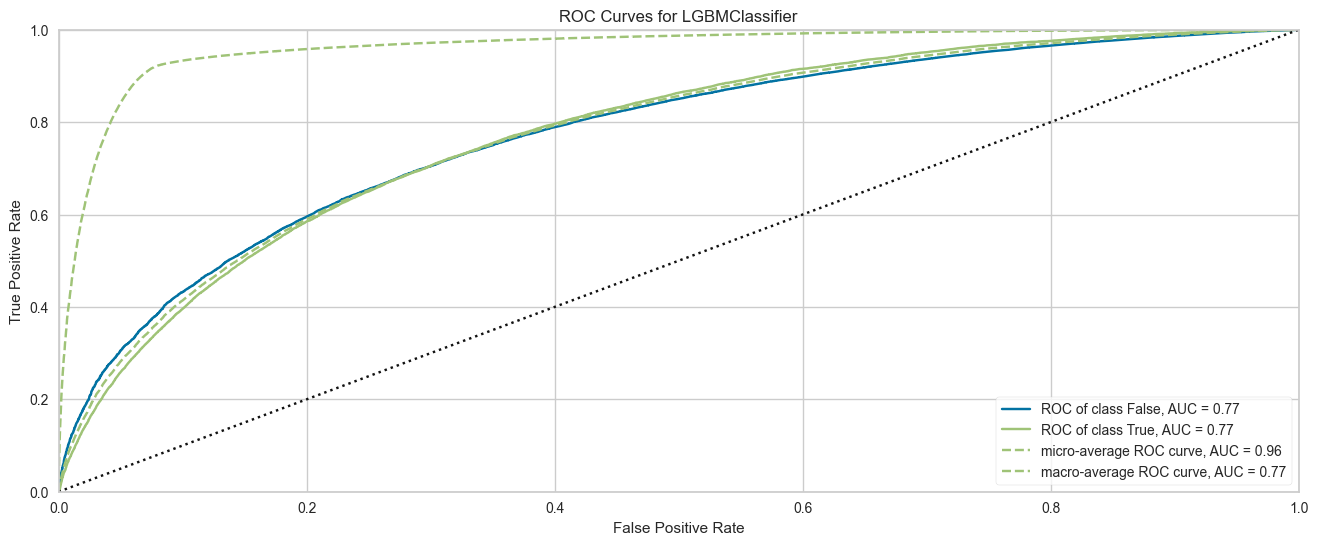

In [78]:
# Plotando o gráfico AUC
plot_model(tuned_lightgbm, plot = 'auc')

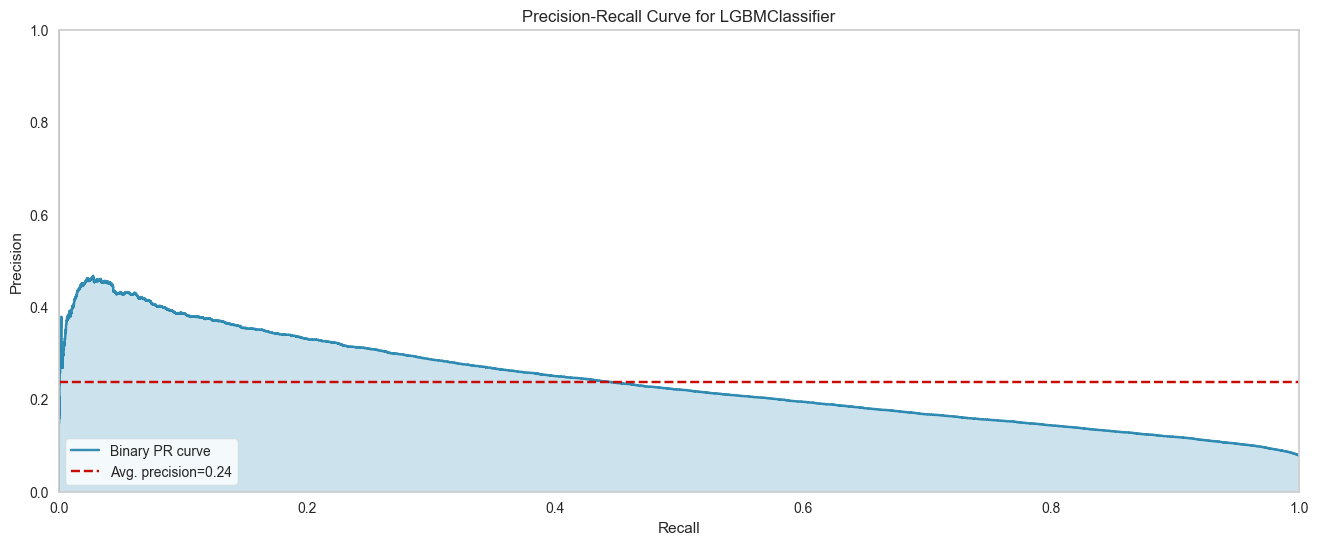

In [79]:
# Plotando o gráfico Precision-Recall
plot_model(tuned_lightgbm, plot = 'pr')

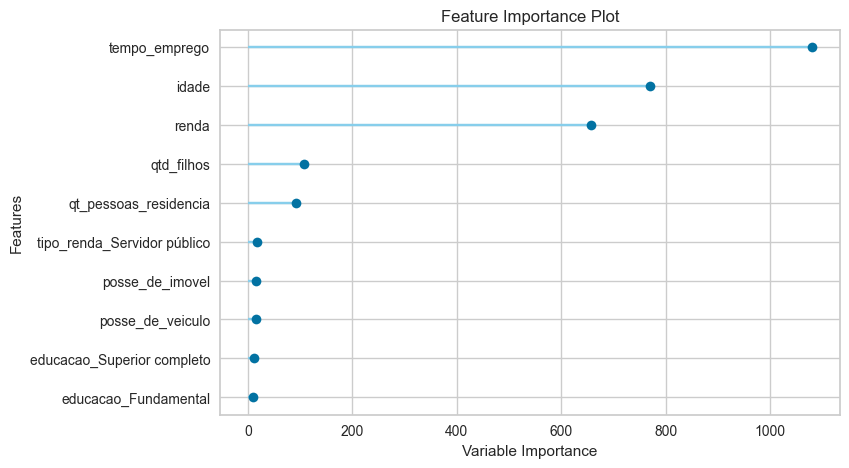

In [80]:
# Plotando o gráfico Importância das variáveis (Feature Importance)
plot_model(tuned_lightgbm, plot = 'feature')

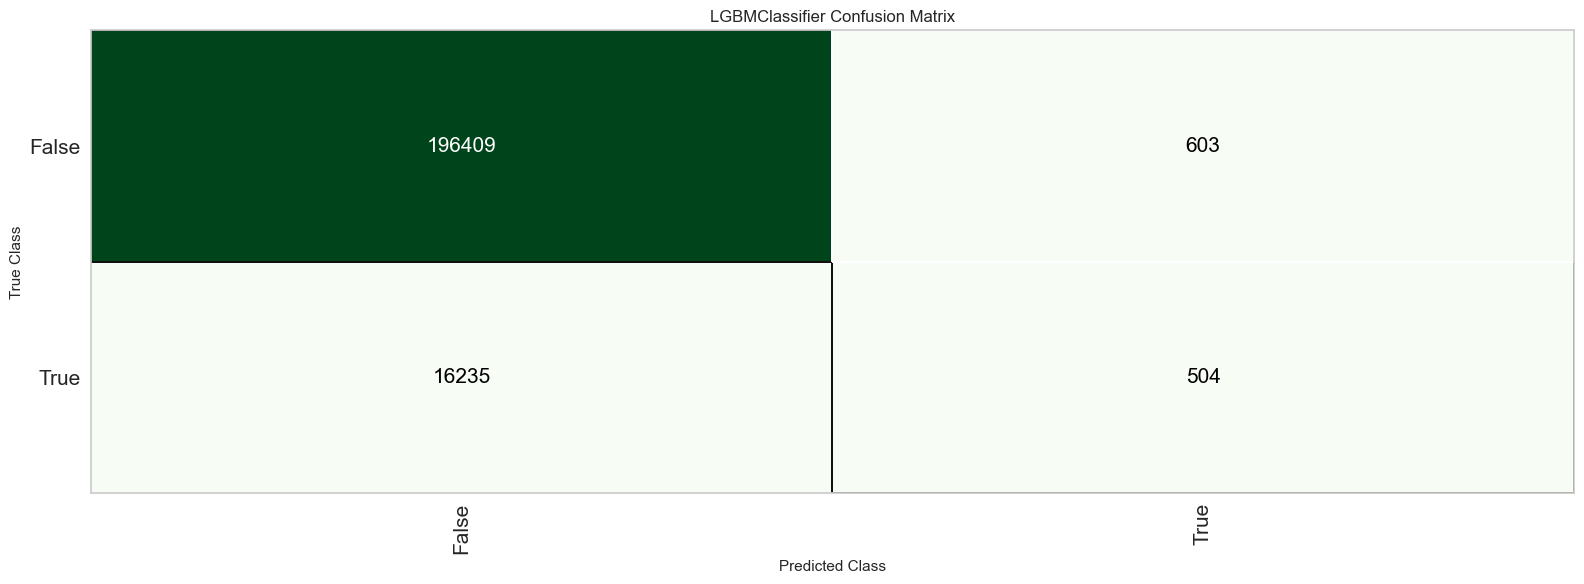

In [81]:
# Plotando o gráfico Matriz de confusão (Confusion matrix)
plot_model(tuned_lightgbm, plot = 'confusion_matrix')

In [82]:
# Predict na base de teste
predict_model(tuned_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9212,0.7742,0.0301,0.4553,0.0565,0.0472,0.1012


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [83]:
# Finalizando o modelo para deploy
final_lightgbm = finalize_model(tuned_lightgbm)

In [84]:
#Parâmetros finais do modelo lightgbm para deploy
print(final_lightgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                boosting_type='gbdt', class_weight=None,
                           

In [85]:
# Predict na base de teste
predict_model(final_lightgbm);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9224,0.7927,0.0324,0.5789,0.0614,0.0536,0.1237


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


In [86]:
# Predizendo o conjunto de dados que não foi usado no treino
unseen_predictions = predict_model(final_lightgbm, data=data_unseen)
unseen_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9233,0.7797,0.0281,0.4255,0.0527,0.0437,0.0937


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
0,F,S,S,2,Servidor público,Fundamental,Casado,Casa,38,15.643836,4.0,4758.299805,False,0,0.9568
1,M,N,S,1,Empresário,Médio,Casado,Casa,38,0.753425,3.0,2506.479980,False,0,0.8513
2,M,S,N,0,Empresário,Médio,Solteiro,Casa,44,1.260274,1.0,936.010010,False,0,0.7174
3,M,S,N,2,Assalariado,Médio,Casado,Casa,49,3.016438,4.0,3996.300049,False,0,0.9137
4,M,S,N,0,Empresário,Médio,Casado,Casa,39,0.827397,2.0,3908.919922,False,0,0.8861


In [87]:
# Predizendo o conjunto de dados de validação do modelo inicial
val_predictions = predict_model(final_lightgbm, data=df_validacao)
val_predictions.head()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8554,0.7476,0.0605,0.5658,0.1094,0.0834,0.1496


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,score,mau,prediction_label,prediction_score
633328,M,N,S,2,Empresário,Fund./Medio,Casado,Casa,43,1.550685,4.0,2491.270020,0.123860,0,0,0.8568
633329,F,S,S,1,Empresário,Pos./Sup. Completo,Solteiro,Casa,27,6.791781,2.0,1477.180054,0.122211,0,0,0.7969
633330,M,S,S,0,Empresário,Pos./Sup. Completo,Casado,Casa,59,9.997260,2.0,5365.120117,0.079861,0,0,0.9395
633331,F,N,S,0,Empresário,Pos./Sup. Completo,Separado,Aluguel,46,3.690411,1.0,595.500000,0.140595,0,0,0.6526
633332,F,N,S,0,Empresário,Fund./Medio,Casado,Casa,39,6.638356,2.0,1247.560059,0.125147,1,0,0.7208


O algorítimo treinado com o Pycaret (lightgbm) apresentou desempenho superior ao primeiro modelo de regressão logística, considerando a mesma base de validação.

### Salvar o arquivo do modelo treinado

In [88]:
# Salvando o modelo final
save_model(final_lightgbm,'lightgbm model_final')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 boosting_type='gbdt', class_weight=None,
            

# Projeto Final

1. Subir no GITHUB todos os jupyter notebooks/códigos que você desenvolveu nesse ultimo módulo
1. Gerar um arquivo python (.py) com todas as funções necessárias para rodar no streamlit a escoragem do arquivo de treino
    - Criar um .py
    - Criar um carregador de csv no streamlit 
    - Subir um csv no streamlit 
    - Criar um pipeline de pré processamento dos dados
    - Utilizar o modelo treinado para escorar a base 
        - nome_arquivo = 'model_final.pkl'
1. Gravar um vídeo da tela do streamlit em funcionamento (usando o próprio streamlit (temos aula disso) ou qlqr outra forma de gravação).
1. Subir no Github o vídeo de funcionamento da ferramenta como README.md.
1. Subir no Github os códigos desenvolvidos. 
1. Enviar links do github para o tutor corrigir.